In [16]:
import numpy as np
import pandas as pd
import scipy.interpolate
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import MinMaxScaler
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, confusion_matrix
from sklearn.feature_selection import SequentialFeatureSelector
from sklearn import tree

import xgboost as xgb
import pickle

from sklearn.dummy import DummyClassifier

In [11]:
# Constants
DATA_FILENAME = "../data/accepted_2007_to_2018Q4_cleared.csv"
# "../data/accepted_2007_to_2018Q4_selected_features.csv"
SAVED_MODEL_PATH = "../models/saved_models/"
IS_TREE_POST_PRUNE = False

In [59]:
# Helpers
def save_model(model, name):
    model_path = SAVED_MODEL_PATH + name + '.sav'
    pickle.dump(model, open(model_path, 'wb'))
    
def load_model(name):
    model_path = SAVED_MODEL_PATH + name + '.sav'
    return pickle.load(open(model_path, 'rb'))

def gini(y, classes):
    probs = []
    for cls in classes:
        probs.append((y == cls).sum() / y.shape[0]) # class probability
        
    p = np.array(probs)
    return 1 - ((p*p).sum())

def gini_index(y_left, y_right, classes=[0, 1]):
    n = y_left.shape[0] + y_right.shape[0]
    p_left = y_left.shape[0] / n
    p_right = y_right.shape[0] / n
    
    return p_left * gini(y_left, classes) + p_right * gini(y_right, classes)

def get_statistics(actual, pred, verbose=True):
    # confusion matrix: C[i, j] -- number of observation that should be in i but predicted in j
    conf_matrix = confusion_matrix(y_true=actual, y_pred=pred)
    true_positive = conf_matrix[1, 1]
    true_negative = conf_matrix[0, 0]
    false_positive = conf_matrix[0, 1]
    false_negative = conf_matrix[1, 0]

    sensitivity = true_positive / (true_positive + false_negative)  # ability to find true (1)
    specificity = true_negative / (true_negative + false_positive)  # ability to find false (0)
    gini_coeff = gini_index(actual, pred)

    if verbose:
        print("Sensitivity:", sensitivity)
        print("Specificity:", specificity)
        print("Gini coefficient:", gini_coeff)

    return (sensitivity, specificity, gini_coeff)

In [32]:
# Test
a = np.array([1,0,0,1,1,1,1])
b = np.array([1,0,0,0,1,0,0, 1, 0])

gini_index(a, b)

0.4285714285714286

### Data loading

In [4]:
# Get data
data = pd.read_csv(DATA_FILENAME)

X = data.drop('loan_status', axis=1)
y = data[['loan_status']]
y = y.values.ravel()

# Normalized data
scaler = MinMaxScaler()
X = scaler.fit_transform(X)

In [5]:
X.shape

(1416437, 12)

In [6]:
y.shape

(1416437,)

### Dummy classifier

In [33]:
def try_dummy(iters=5):
    score_list = []
    sensitivity_list = []
    specificity_list = []
    gini_coeff_list = []
    
    for i in range(iters):
        x_train, x_test, y_train, y_test = train_test_split(X, y, test_size=0.25, stratify=y)

        dummy_clf = DummyClassifier(strategy="most_frequent")
        dummy_clf.fit(x_train, y_train)
        dummy_pred = dummy_clf.predict(x_test)
        
        score_list.append(dummy_clf.score(x_test, y_test))
        sensitivity, specificity, gini_coeff = get_statistics(y_test, dummy_pred, 
                                                              verbose=False)
        sensitivity_list.append(sensitivity)
        specificity_list.append(specificity)
        gini_coeff_list.append(gini_coeff)
        
    # Get best result
    best_ind = np.array(score_list).argmax()
    print("Accuracy:", score_list[best_ind])
    print("Sensitivity:", sensitivity_list[best_ind])
    print("Specificity:", specificity_list[best_ind])
    print("Gini coefficient:", gini_coeff_list[best_ind])
    
try_dummy()

Accuracy: 0.8582954449182457
Sensitivity: 0.0
Specificity: 1.0
Gini coefficient: 0.12162437415083638


### Logistic regression

In [34]:
def log_regression(X=X, y=y, iters=5):
    score_list = []
    sensitivity_list = []
    specificity_list = []
    gini_coeff_list = []
    models = []

    for i in range(iters):
        x_train, x_test, y_train, y_test = train_test_split(X, y, test_size=0.25, stratify=y)

        logistic_reg = LogisticRegression()
        logistic_reg.fit(x_train, y_train)
        log_reg_pred = logistic_reg.predict(x_test)
        log_reg_score = logistic_reg.score(x_test, y_test)

        score_list.append(log_reg_score)
        sensitivity, specificity, gini_coeff = get_statistics(y_test, log_reg_pred, 
                                                              verbose=False)
        sensitivity_list.append(sensitivity)
        specificity_list.append(specificity)
        gini_coeff_list.append(gini_coeff)
        models.append(logistic_reg)

    # Get best result
    best_ind = np.array(score_list).argmax()
    print("Accuracy:", score_list[best_ind])
    print("Sensitivity:", sensitivity_list[best_ind])
    print("Specificity:", specificity_list[best_ind])
    print("Gini coefficient:", gini_coeff_list[best_ind])

    save_model(models[best_ind], "logistic_reg")

log_regression()

Accuracy: 0.8576656970997713
Sensitivity: 0.031686562107654595
Specificity: 0.9940348302739767
Gini coefficient: 0.13114203008297887


### Logistic regression with Forest weights

In [35]:
def log_reg_weighted(X=X, y=y, iters=5):
    score_list = []
    sensitivity_list = []
    specificity_list = []
    gini_coeff_list = []
    models = []

    for i in range(iters):
        x_train, x_test, y_train, y_test = train_test_split(X, y, test_size=0.25, stratify=y)

        random_forest = RandomForestClassifier(n_estimators=5)  # TODO: Play with higher n_estimators
        random_forest.fit(x_train, y_train)

#         top_n_features = 5
#         selected_features_ind = random_forest.feature_importances_.argsort()[:top_n_features]
#         x_train_selected = x_train[:, selected_features_ind]
#         x_test_selected = x_test[:, selected_features_ind]

        forest_log_reg = LogisticRegression(
            class_weight=dict(zip(range(len(random_forest.feature_importances_)),
                                  random_forest.feature_importances_)))

        forest_log_reg = LogisticRegression()
        forest_log_reg.fit(x_train, y_train)
        forest_log_reg_pred = forest_log_reg.predict(x_test)
        forest_log_reg_score = forest_log_reg.score(x_test, y_test)

        score_list.append(forest_log_reg_score)
        sensitivity, specificity, gini_coeff = get_statistics(y_test, forest_log_reg_pred, 
                                                              verbose=False)
        sensitivity_list.append(sensitivity)
        specificity_list.append(specificity)
        gini_coeff_list.append(gini_coeff)
        models.append(forest_log_reg)

    best_ind = np.array(score_list).argmax()
    print("Accuracy:", score_list[best_ind])
    print("Sensitivity:", sensitivity_list[best_ind])
    print("Specificity:", specificity_list[best_ind])
    print("Gini coefficient:", gini_coeff_list[best_ind])

    save_model(models[best_ind], "forest_log_reg")
    
log_reg_weighted()

Accuracy: 0.8575527378498207
Sensitivity: 0.03310149664202156
Specificity: 0.9936696158009548
Gini coefficient: 0.13164585210287127


### Stepwise logistic regression

In [37]:
def stepwise_feature_selection(X=X, y=y, iters=3):
    score_list = []
    sensitivity_list = []
    specificity_list = []
    gini_coeff_list = []
    models = []

    for i in range(iters):
        x_train, x_test, y_train, y_test = train_test_split(X, y, test_size=0.25, stratify=y)

        logistic_reg = LogisticRegression()
        sfs = SequentialFeatureSelector(logistic_reg, n_features_to_select='auto', cv=5)

        sfs.fit(x_train, y_train)
        selected_features = sfs.get_support()
        print("Selected features:", selected_features)
        
        x_train_selected = sfs.transform(x_train)
        x_test_selected = sfs.transform(x_test)

        log_reg = LogisticRegression()
        log_reg.fit(x_train_selected, y_train)
        log_reg_pred = log_reg.predict(x_test_selected)
        log_reg_score = log_reg.score(x_test_selected, y_test)

        score_list.append(log_reg_score)
        sensitivity, specificity, gini_coeff = get_statistics(y_test, log_reg_pred, 
                                                              verbose=False)
        sensitivity_list.append(sensitivity)
        specificity_list.append(specificity)
        gini_coeff_list.append(gini_coeff)
        models.append(log_reg)

    best_ind = np.array(score_list).argmax()
    print("Accuracy:", score_list[best_ind])
    print("Sensitivity:", sensitivity_list[best_ind])
    print("Specificity:", specificity_list[best_ind])
    print("Gini coefficient:", gini_coeff_list[best_ind])

    save_model(models[best_ind], "stepwise_log_rec")
    
stepwise_feature_selection()

Selected features: [ True  True False False  True  True  True  True False False False False]
Selected features: [ True  True False False  True  True  True  True False False False False]
Selected features: [ True  True False False  True  True  True  True False False False False]
Selected features: [ True  True False False  True  True  True  True False False False False]
Selected features: [ True  True False False  True  True  True  True False False False False]
Accuracy: 0.8582954449182457
Sensitivity: 0.0
Specificity: 1.0
Gini coefficient: 0.12162437415083638


### Xgboost on the default parameters

In [38]:
def run_xgboost(X=X, y=y, iters=5):
    score_list = []
    sensitivity_list = []
    specificity_list = []
    gini_coeff_list = []
    models = []

    for i in range(iters):
        x_train, x_test, y_train, y_test = train_test_split(X, y, test_size=0.25, stratify=y)

        xgb_classifier = xgb.XGBClassifier()
        xgb_classifier.fit(x_train, y_train)
        y_test_pred = xgb_classifier.predict(x_test)

        score_list.append(accuracy_score(y_test, y_test_pred))
        sensitivity, specificity, gini_coeff = get_statistics(y_test, y_test_pred, 
                                                              verbose=False)
        sensitivity_list.append(sensitivity)
        specificity_list.append(specificity)
        gini_coeff_list.append(gini_coeff)
        models.append(xgb_classifier)

    # Get best result
    best_ind = np.array(score_list).argmax()
    print("Accuracy:", score_list[best_ind])
    print("Sensitivity:", sensitivity_list[best_ind])
    print("Specificity:", specificity_list[best_ind])
    print("Gini coefficient:", gini_coeff_list[best_ind])

    save_model(models[best_ind], "xgb_classifier")

run_xgboost()

Accuracy: 0.8582982688994945
Sensitivity: 0.017537216763984936
Specificity: 0.9971078962001244
Gini coefficient: 0.12656708227337976


### Xgboost with tuned hyper-parameters

In [53]:
default_params = {}
xgb_tuned_cl = xgb.XGBClassifier()

grid_cv = GridSearchCV(xgb_tuned_cl, scoring='accuracy', 
                       param_grid=default_params,
                       return_train_score=True, verbose=1, cv=3)
grid_cv.fit(x_train, y_train)
pd.DataFrame(grid_cv.cv_results_)

Fitting 3 folds for each of 1 candidates, totalling 3 fits


,mean_fit_time,std_fit_time,mean_score_time,std_score_time,params,split0_test_score,split1_test_score,split2_test_score,mean_test_score,std_test_score,rank_test_score,split0_train_score,split1_train_score,split2_train_score,mean_train_score,std_train_score
0,30.065092,0.115259,0.217087,0.003277,{},0.858371,0.8581,0.858179,0.858217,0.000114,1,0.860045,0.860128,0.860272,0.860148,0.000094


In [52]:
xgb_tuned_cl.get_params()

{'objective': 'binary:logistic',
 'use_label_encoder': False,
 'base_score': None,
 'booster': None,
 'callbacks': None,
 'colsample_bylevel': None,
 'colsample_bynode': None,
 'colsample_bytree': None,
 'early_stopping_rounds': None,
 'enable_categorical': False,
 'eval_metric': None,
 'gamma': None,
 'gpu_id': None,
 'grow_policy': None,
 'importance_type': None,
 'interaction_constraints': None,
 'learning_rate': None,
 'max_bin': None,
 'max_cat_to_onehot': None,
 'max_delta_step': None,
 'max_depth': None,
 'max_leaves': None,
 'min_child_weight': None,
 'missing': nan,
 'monotone_constraints': None,
 'n_estimators': 100,
 'n_jobs': None,
 'num_parallel_tree': None,
 'predictor': None,
 'random_state': None,
 'reg_alpha': None,
 'reg_lambda': None,
 'sampling_method': None,
 'scale_pos_weight': None,
 'subsample': None,
 'tree_method': None,
 'validate_parameters': None,
 'verbosity': None}

In [72]:
def run_tuned_xgboost(X=X, y=y, iters=1):
    score_list = []
    sensitivity_list = []
    specificity_list = []
    gini_coeff_list = []
    models = []
    
    xgb_grid_params = {
#         'gamma': [0,0.1,0.2,0.4,0.8,1.6,3.2],
#         'learning_rate': [0.01, 0.03, 0.06, 0.1, 0.15, 0.2, 0.25, 0.3, 0.4],
#         'max_depth': [4,5,6,7,8,9,10,11,12,13,14],
#         'n_estimators': [50,65,80,100,115,130,150],
#         'reg_alpha': [0,0.1,0.2,0.4,0.8,1.6,3.2,6.4],
#         'reg_lambda': [0,0.1,0.2,0.4,0.8,1.6,3.2,6.4]
        
        "max_depth": [5, 6], # 4, 7],
        "learning_rate": [0.3, 0.1], #, 0.01], #, 0.05],
        "gamma": [0, 0.25], #, 0.5, 1],
        "reg_lambda": [0, 1], # , 2], #, 10],
        "scale_pos_weight": [1, 3], #, 5],
        "subsample": [1], #[0.8, 1],
        "colsample_bytree": [1], # [0.5, 1],
    }

    for i in range(iters):
        x_train, x_test, y_train, y_test = train_test_split(X, y, test_size=0.25, stratify=y)

        xgb_tuned_cl = xgb.XGBClassifier()
        grid_cv = GridSearchCV(xgb_tuned_cl, scoring='accuracy', 
                               param_grid=xgb_grid_params, verbose=2, cv=2)
        grid_cv.fit(x_train, y_train)
        
        y_test_pred = grid_cv.predict(x_test)

        score_list.append(accuracy_score(y_test, y_test_pred))
        sensitivity, specificity, gini_coeff = get_statistics(y_test, y_test_pred, 
                                                              verbose=False)
        sensitivity_list.append(sensitivity)
        specificity_list.append(specificity)
        gini_coeff_list.append(gini_coeff)
        
        best_xgboost = grid_cv.best_estimator_
        models.append(best_xgboost)

    # Get best result
    best_ind = np.array(score_list).argmax()
    print("Accuracy:", score_list[best_ind])
    print("Sensitivity:", sensitivity_list[best_ind])
    print("Specificity:", specificity_list[best_ind])
    print("Gini coefficient:", gini_coeff_list[best_ind])

    save_model(models[best_ind], "xgb_tuned_classifier")

run_tuned_xgboost()

Fitting 2 folds for each of 32 candidates, totalling 64 fits
[CV] END colsample_bytree=1, gamma=0, learning_rate=0.3, max_depth=5, reg_lambda=0, scale_pos_weight=1, subsample=1; total time=  16.5s
[CV] END colsample_bytree=1, gamma=0, learning_rate=0.3, max_depth=5, reg_lambda=0, scale_pos_weight=1, subsample=1; total time=  16.2s
[CV] END colsample_bytree=1, gamma=0, learning_rate=0.3, max_depth=5, reg_lambda=0, scale_pos_weight=3, subsample=1; total time=  16.3s
[CV] END colsample_bytree=1, gamma=0, learning_rate=0.3, max_depth=5, reg_lambda=0, scale_pos_weight=3, subsample=1; total time=  16.8s
[CV] END colsample_bytree=1, gamma=0, learning_rate=0.3, max_depth=5, reg_lambda=1, scale_pos_weight=1, subsample=1; total time=  16.4s
[CV] END colsample_bytree=1, gamma=0, learning_rate=0.3, max_depth=5, reg_lambda=1, scale_pos_weight=1, subsample=1; total time=  16.5s
[CV] END colsample_bytree=1, gamma=0, learning_rate=0.3, max_depth=5, reg_lambda=1, scale_pos_weight=3, subsample=1; total 

[CV] END colsample_bytree=1, gamma=0.25, learning_rate=0.1, max_depth=6, reg_lambda=1, scale_pos_weight=1, subsample=1; total time=  21.6s
[CV] END colsample_bytree=1, gamma=0.25, learning_rate=0.1, max_depth=6, reg_lambda=1, scale_pos_weight=1, subsample=1; total time=  21.6s
[CV] END colsample_bytree=1, gamma=0.25, learning_rate=0.1, max_depth=6, reg_lambda=1, scale_pos_weight=3, subsample=1; total time=  21.8s
[CV] END colsample_bytree=1, gamma=0.25, learning_rate=0.1, max_depth=6, reg_lambda=1, scale_pos_weight=3, subsample=1; total time=  21.6s
Accuracy: 0.858340628618226
Sensitivity: 0.007413459813866359
Specificity: 0.998828681509948
Gini coefficient: 0.12367600594638539


In [ ]:
# Results from previous run:
# Accuracy: 0.727159598535079
# Best parameters: {'colsample_bytree': 1, 'gamma': 0.25, 'learning_rate': 0.3, 
# 'max_depth': 5, 'reg_lambda': 1, 'scale_pos_weight': 3, 'subsample': 1}
# Sensitivity: 0.3214093545108512
# Specificity: 0.8914358851186618

### Pruning tree

In [56]:
def run_pruning_tree(X=X, y=y, iters=1):
    score_list = []
    sensitivity_list = []
    specificity_list = []
    gini_coeff_list = []
    models = []
    
    pruning_params = {
        'max_depth': [2, 4, 6, 15],
        'min_samples_split': [2, 3, 4],
        'min_samples_leaf': [1, 2]
    }

    for i in range(iters):
        x_train, x_test, y_train, y_test = train_test_split(X, y, test_size=0.25, stratify=y)

        prun_cl = tree.DecisionTreeClassifier()
        tree_grid_cv = GridSearchCV(estimator=prun_cl, scoring='accuracy', 
                                    param_grid=pruning_params, verbose=1, cv=3)
        tree_grid_cv.fit(x_train, y_train)
        
        y_test_pred = tree_grid_cv.predict(x_test)

        score_list.append(accuracy_score(y_test, y_test_pred))
        sensitivity, specificity, gini_coeff = get_statistics(y_test, y_test_pred, 
                                                              verbose=False)
        sensitivity_list.append(sensitivity)
        specificity_list.append(specificity)
        gini_coeff_list.append(gini_coeff)
        
        prune_best_tree = tree_grid_cv.best_estimator_
        models.append(prune_best_tree)

    # Get best result
    best_ind = np.array(score_list).argmax()
    print("Accuracy:", score_list[best_ind])
    print("Sensitivity:", sensitivity_list[best_ind])
    print("Specificity:", specificity_list[best_ind])
    print("Gini coefficient:", gini_coeff_list[best_ind])

    save_model(models[best_ind], "prune_tree_cls")

run_pruning_tree()

Fitting 3 folds for each of 24 candidates, totalling 72 fits
Accuracy: 0.8582954449182457
Sensitivity: 0.0
Specificity: 1.0
Gini coefficient: 0.12162437415083638


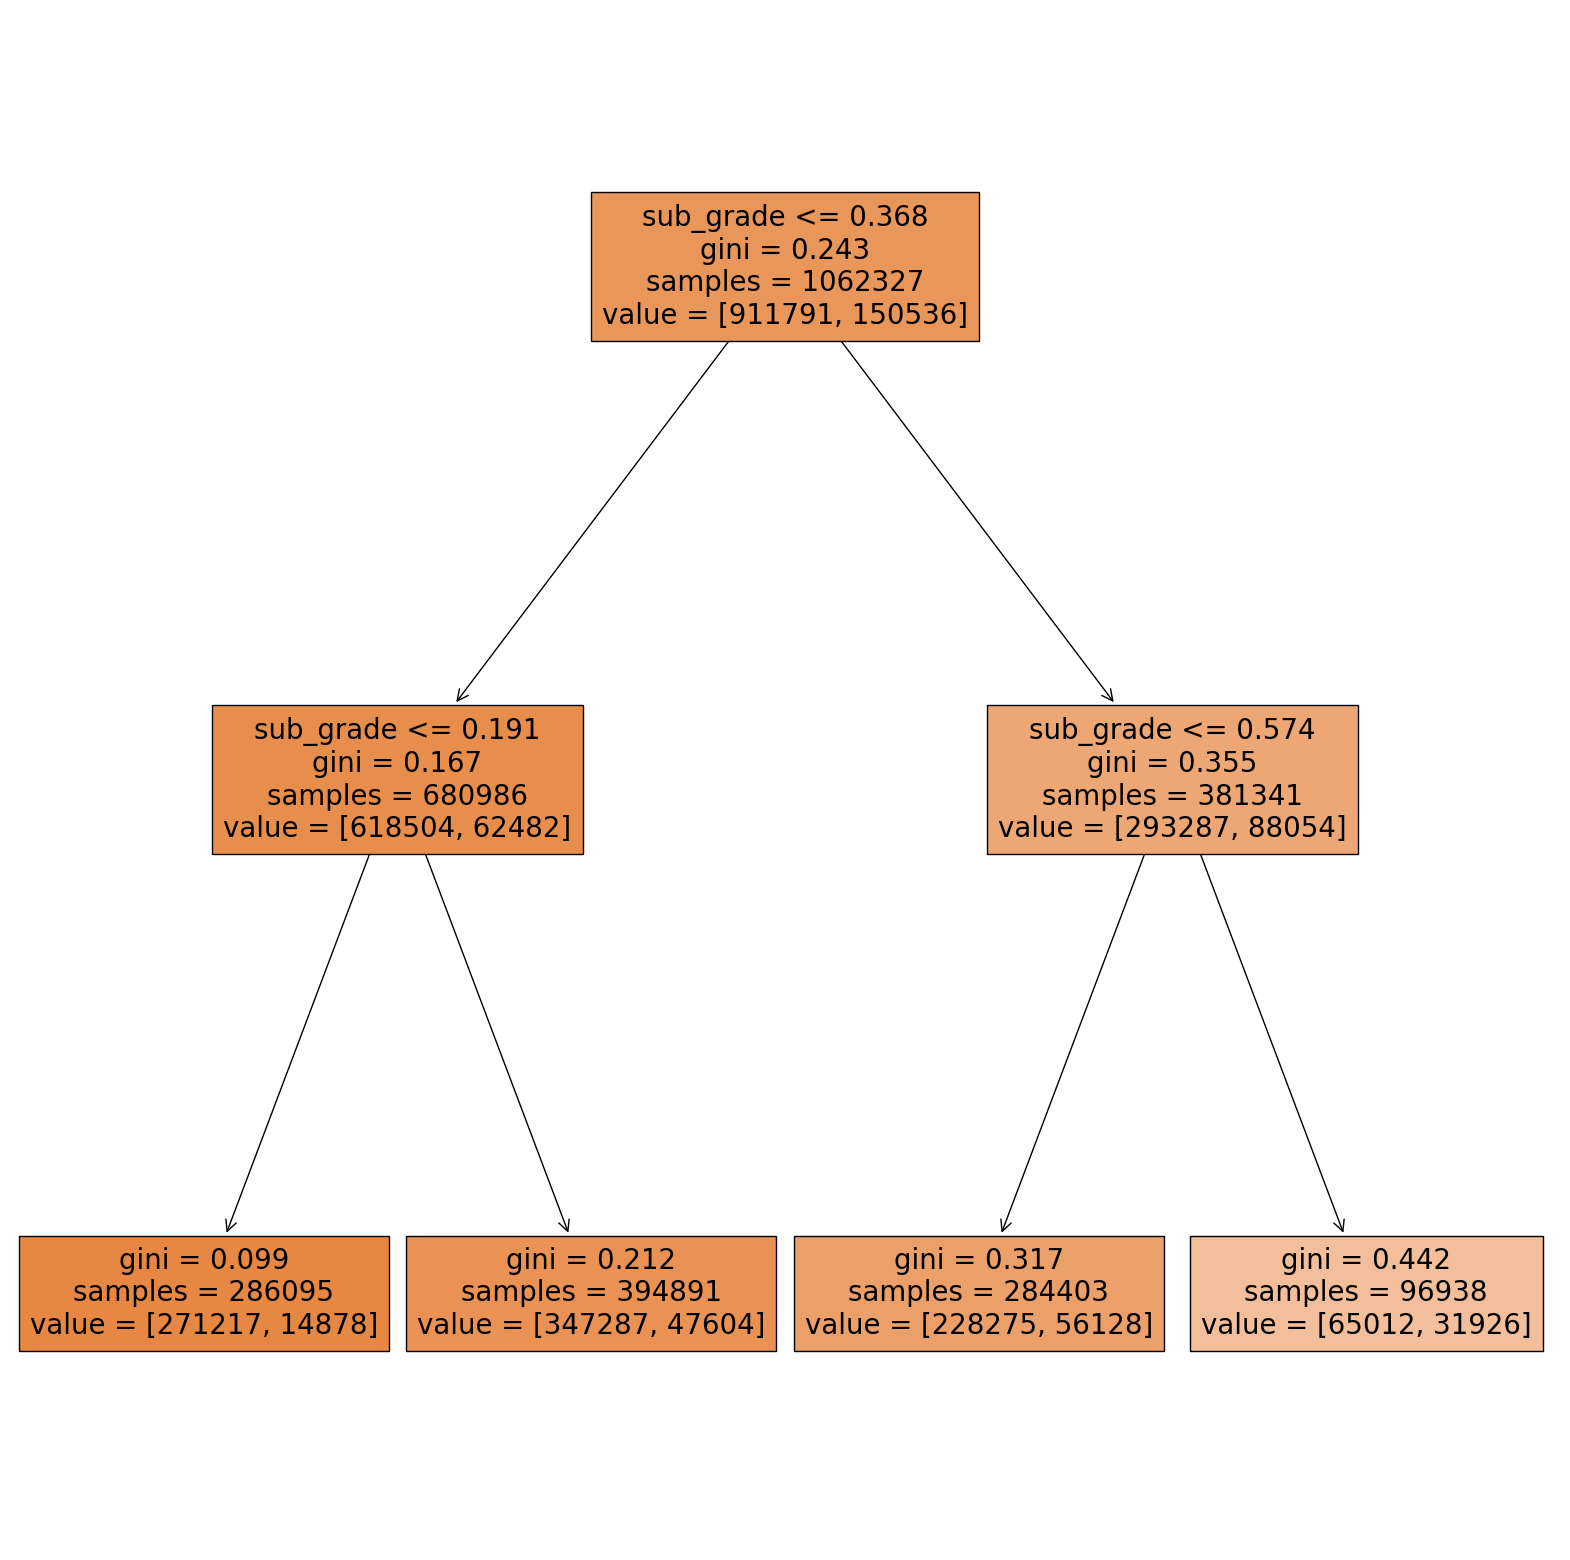

In [60]:
# Visualize
tree_model = load_model("prune_tree_cls")

plt.figure(figsize=(20, 20))
tree.plot_tree(tree_model, feature_names=data.columns, filled=True)
plt.show()